<a href="https://colab.research.google.com/github/jodejetalo99/Computacion_Estadistica/blob/main/proyecto_Jose_Tapia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad Nacional Autónoma de México
# Instituto de Investigaciones en Matemáticas Aplicadas y en Sistemas
# Computación Estadística
# Profesor: Alan Riva Palacio Cohen
# Ayudante: Marco Antonio Gallegos Herrada
# Proyecto
# Alumno: José de Jesús Tapia López
# 14 de Junio de 2021





# Objetivos

Uno de los objetivos de este proyecto es estimar de una manera no convencional los coeficientes en una regresión logística. Con esto nos referimos a realizarlo por medio de MCMC, específicamente usando Metropolis-Hastings (M-H). Realmente queremos ejemplificar este algoritmo con una base de datos con pocos datos, más que nada para comprobar que obtenemos buenas estimaciones (principalmente, verificar que converjan).

De igual manera, queremos comparar los resultados de dichas estimaciones (usando M-H) con las que obtenemos mediante MLE, el cual es el método que generalmente se utiliza para estimar los coeficientes en la regresión logístico (De hecho, no solamente en la regresión logísitca, en otros modelos lineales generalizados también). Además, a través de otros dos modelos estimaremos los coeficientes utilizando STAN, para igualmente comparar estas últimas estimaciones.

Finalmente, pretendemos decir con cuál modelo obtenemos un mejor rendimiento, evaluándolos con su eactitud (accuracy). 

# Introducción

La educación es el proceso de enseñanza o aprendizaje, especialmente en una escuela o universidad; también se define como el conocimiento que obtienes de esto, con la principal finalidad de que los estudiantes en un futuro puedan desarrollarse en una vida laboral y al mismo tiempo tener la capacidad de satisfacer sus propias necesidades. 

La baja calidad de la educación en México ha sido un obstáculo para el crecimiento y el desarrollo, sin obtener la posibilidad de reducir los niveles de desigualdad y pobreza, lo cual se considera que es una realidad que sigue vigente hasta la actualidad. A pesar de que se implementen nuevas reformas; estas no son dirigidas a establecer un sistema educativo que solucione problemas de raíz como lo son la corrupción, la falta de transparencia y la falta de valores.

Además, como estudiante universitario, a veces pensamos mucho en los exámenes y en la mejor manera en la que podemos atacarlos. No sabemos si realmente la clave está en estudiar muchas horas, o mejor poner toda la atención a las clases y estudiar poco, o simplemente no estudiar antes del examen para mantenernos relajados.Sin embargo, en gran medida creo que todo va a depender de los hábitos y prioridades de cada alumno.

¿Qué tan útil sería predecir si algunos de estudiantes aprobarán o no un examen? Esta predicción puede basarse en distintas características conocidas sobre cada estudiante. Por ejemplo, la cantidad de horas que estudian, la cantidad de ejercicios que resuelven, etc.

Para tratar de resolver esta tarea, podemos usar algoritmos estadísticos para predecir si una determinada persona  aprobará o reprobará un examen. Más específicamente, podemos usar la regresión logística para hacer esto, el cual es uno de los algoritmos de clasificación más usado. 


# Fuente de datos

Esta información se obtuvo del siguiente [link](https://github.com/dhirajk100/LogReg01/blob/master/Student-Pass-Fail-Data.csv).

Los datos cargados tienen tres variables:

* **Self\_Study\_Daily**: indica cuántas horas estudia el estudiante diariamente en casa.
* **Tuition\_Monthly**: indica cuántas horas al mes el estudiante está tomando clases particulares con tutores.
* **Pass\_or\_Fail**: Es etiqueta en el conjunto de datos, cual puede tomar dos posibles valores: 
    
        - 1: indica que el estudiante aprobó el examen
        - 0: indica que el estudiante reprobó el examen.

La base de datos tiene un total del 1000 registros.

También es importante mencionar que para los fines de este proyecto únicamente vamos a considerar a una variable explicativa: **Self\_Study\_Daily**.


# Desarrollo: Regresión Logística usando el algoritmo de Metrópolis-Hastings

## Un poco de teoría

En clase vimos el algoritmo de MCMC Metropolis-Hastings, el cual podemos adaptarlo para ajustar los coeficientes en un modelo de regresión logística. Los parámetros que se estiman son $\beta_j$ para $ j = 1,2, ... k$, donde $k$ es el número de variables independientes del modelo. La principal diferencia es que habrá varios parámetros para estimar en lugar de uno. Para trata esto, vamos a generar propuestas para cada $\beta_j$ en cada simulación, pero aleatorizando el orden de los $\beta_j$ en cada simulación.

Para construir dicho algoritmo MCMC Metropolis-Hastings para que se ajuste a un modelo de regresión logística, necesitamos definir 4 funciones. Estas nos permitirán calcular la razón de nuestra distribución a posteriori para $\beta_j$ propuestos en cada paso del algoritmo MCMC. El primero también nos ayudará a predecir probabilidades a partir de nuestro modelo.

* La primera es $\textit{logitInv}$, que calcula la inversa de la función liga $\textit{logit}$. La función logit traduce una probabilidad en log-momios $ln(\frac{p}{1-p})$, donde $p \in (0,1)$ es la probabilidad. Recordemos que la regresión logística es un tipo de Modelo Lineal Generalizado. Esta se usa para modelar proporciones, las cuales no pueden tener distribución normal ya que los valores están restringidos en el intervalo $(0,1)$. Para este proyecto, vamos a asumir un modelo con una sola variable explicativa $X$ con valores $x$, tendríamos entonces un modelo de la forma:
    
    $$ log\bigg(\frac{p}{1-p}\bigg) = \beta_0 + \beta_1x$$
    
  Como la $p$ es función de las variables explicativas, entonces $p$ es función de $x$ y podemos denotarla como $p(x)$. Haciendo el despeje correspondiente tenemos que:
    
    $$ p(x)  = \frac{exp(\beta_0 + \beta_1x)}{1 + exp(\beta_0 + \beta_1x)}$$
    
  La salida de la regresión logística está en formato log-momios. Necesitamos esta función para traducir las probabilidades logarítmicas pronosticadas en probabilidades al calcular la probabilidad logarítmica de nuestro vector $\beta$ dados nuestros datos. Entonces, nuestro vector de probabilidades predichas es:  $p = p(x)  = \frac{exp(\beta_0 + \beta_1x)}{1 + exp(\beta_0 + \beta_1x)}$.
    
* La segunda es  $\textit{logPrioriNormal}$, que calcula el logaritmo de la a priori de nuestro vector $\beta$ dadas nuestras creencias anteriores sobre las medias y las desviaciones estándar de las $\beta_j$ individuales, asumiendo que nuestras $\beta_j$ están distribuidas normalmente. Es la suma del logaritmo natural de las a prioris $f_{\underset{\sim}{\beta_j}}(\beta_j)$ del vector aleatorio $N \sim (\mu_j,\sigma_j)$ en $\beta$, donde $\mu_j$ es la media a priori y $\sigma_j$ es la desviación estándar a priori en $j$.

* La tercera es $\textit{logVerosimilitud}$, que calcula el logaritmo de la probabilidad de nuestro vector $\beta$ dados los datos. Como estamos modelando un problema de 2 clases con nuestra regresión logística, una sola observación tiene una función de masa de probabilidad correspondiente a la de una Bernoulli: 
    $$ P (Y_i = y_i | X_i = x_i) = p_i ^ {y_i} \cdot (1 - p_i) ^ { 1 - y_i} $$ 
    
  La función de verosimilitud de nuestro vector $\beta$ dados los datos es el producto de las funciones de masa de probabilidad individuales: 
    $$f_{Y|\underset{\sim}{\beta}}(y|\beta) =\prod^{n}_{i = 1} \hat {p} _i ^ {y_i} \cdot (1 - \hat{p} _i) ^ {1 -y_i}$$
    
  Y la log-verosimilitud está dada por: 
    
    $$log\Big(f_{Y|\underset{\sim}{\beta}}(y|\beta)\Big) = \sum^{n}_{i = 1}\bigg[log (\hat{p} _i ^ {y_i}) + log ((1 - \hat{p} _i) ^ {1 - y_i})\bigg] = \sum^{n} _ {i = 1} \bigg[y_i \cdot log (\hat{p} _i) + (1 - y_i) \cdot log (1 - \hat{p} _i)\bigg]$$

* Finalmente, $\textit{logPosteriori}$ calcula el logaritmo de la probabilidad a posteriori del vector $\beta$ dados los datos y nuestras creencias previas.
    
  Recordemos que: 
  $$f_{\underset{\sim}{\beta}|Y}(\beta|y) \propto f_{\underset{\sim}{\beta}}(\beta) * f_{Y|\underset{\sim}{\beta}}(y|\beta)$$
    
  Por lo cual: $$log\Big(f_{\underset{\sim}{\beta}|Y}(\beta|y)\Big) \propto log\Big(f_{\underset{\sim}{\beta}}(\beta)\Big) + log\Big(f_{Y|\underset{\sim}{\beta}}(y|\beta)\Big)$$.

Es importante mencionar que utilizaremos el logaritmo lo más que podamos para evitar desbordamiento.

Por lo tanto, el algoritmo de Metrópolis-Hastings (MH) para este proyecto queda de la siguiente manera:

1. Inicializamos las $\hat{\beta_j}^{(0)}$, con $j=0,...,k$ (el cero para tomar en cuenta el intercepto) con la a priori, que en nuestro caso colocaremos $\hat{\beta_j}^{(0)} = 0$, para $j=0,...,k$.
    
2. En cada iteración $t$:
    
    2.1 Simulamos $U \sim Unif(0,1)$

    2.2 Generamos un número $a_j$ proveniente de una distribución normal $N(0, \sigma_j)$ (donde $\sigma_j$ es la desviación estándar del kernel de transición de probabilidad $q_{\underset{\sim}{\beta}}(\beta|\beta_{t-1})$).
        
    2.3 Generamos una beta propuesta $\beta_{prop,j}$ sumando el número $a_j$ y la beta $\hat{\beta_j}^{(t)}$:
        
  $$\beta_{prop,j}^{(t)} = \hat{\beta_j}^{(t)}+ a_j, \text{ para } j= 0,...,k$$
    
    2.4 Obtenemos un vector para todas las $\hat{\beta_j}^{(t)}$ más recientes, para $j= 0,...,k$.
      
        
3. Aceptamos $\hat{\beta_j}^{(t)}=\beta_{prop,j}^{(t)}$ (para kernels de transición simétricos se cumple que $q_{\underset{\sim}{\beta}}(\beta^{(t-1)}_j|\beta_{prop,j}^{(t)}) = q_{\underset{\sim}{\beta}}(\beta_{prop,j}^{(t)}|\beta^{(t-1)}_j)$) si se cumple que:

![](https://raw.githubusercontent.com/jodejetalo99/Computacion_Estadistica/main/Imagenes/CE_Proy_2.jpg)
    
    




## Código

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, mode
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import accuracy_score

# para el parametro de las betas estimadas creamos un arreglo de numpy de tamanio 1
# sin inicializar entradas
beta_hat = np.empty(1)

# función para traducir log-momios a probabilidades
logitInv = lambda beta, X: (np.exp(np.matmul(X, beta.reshape((-1, 1)))) / 
                (1 + np.exp(np.matmul(X, beta.reshape((-1, 1))))))

# función para calcular el logaritmo  de la a priori utilizando 
# una log-normal como distribucion a priori
logPrioriNormal = lambda beta, priori_medias, priori_desv_est: np.sum(norm.logpdf(beta, loc=priori_medias.reshape((-1, 1)), 
                                                                                scale=priori_desv_est.reshape((-1, 1)))) 

# función para calcular la log-verosimilitud de las betas dados los datos.
logVerosimilitud = lambda y, X, beta: np.sum(y * np.log(logitInv(beta.reshape((-1, 1)), X)) + 
                                              (1-y)*np.log(( 1- logitInv(beta.reshape((-1,1)),X)) ))

# función para calcular la log-posteriori de las betas dada la 
# log-verosimilitud y la log-priori asumiendo una a priori normal.
logPosteriori = lambda y, X, beta, priori_medias, priori_desv_est: logPrioriNormal(beta, priori_medias, priori_desv_est) + logVerosimilitud(y, X, beta)

def metropolisHastings(y, X, beta_prioris, priori_desv_est, kernel_desv_est, Nsim):

    # agregamos el intercepto
    X = np.append(np.ones(shape=(X.shape[0], 1)),X, 1)
        
    # crea una lista de indices beta que se repetirán en cada iteración
    indices_beta = [x for x in range(len(beta_prioris))]
    
    # Inicializamos la beta_hat con las a prioris.El numero de filas
    # corresponde al número de coeficientes beta y el un número de 
    # columnas corresponde al número de iteraciones + 1 para la a priori. 
    # Cada fila mantiene valores de un solo coeficiente. 
    # Cada columna es una iteración  del algoritmo.
    beta_hat = np.array(np.repeat(beta_prioris, Nsim+1))
    beta_hat = beta_hat.reshape((beta_prioris.shape[0], Nsim+1))
    
    # iteraciones: 
    for i in range(1, Nsim + 1):
        
        # hacemos un shuffle a los índices beta para que el orden de 
        # los coeficientes en el paso de MH sea aleatorio
        np.random.shuffle(indices_beta)
        
        # generamos el muestreo para cada hat_beta
        for j in indices_beta:
            
            # generamos una beta propuesta usando una distribucion normal
            # y la beta_hat_j 
            beta_j_propuesta = beta_hat[j, i-1] + norm.rvs(loc=0, scale=kernel_desv_est[j])
            
            # obtenemos un vector para todas las betas más recientes 
            beta_nueva = beta_hat[:, i-1].reshape((-1, 1))
            
            # copiamos el vector beta actual e insertamos la propuesta beta_j
            # en el j-esimo índice 
            beta_prop = np.copy(beta_nueva)
            beta_prop[j, 0] = beta_j_propuesta
            
            # calculamos la probabilidad a posteriori de la beta propuesta
            log_p_propuesta = logPosteriori(y, X, beta_prop, beta_nueva, priori_desv_est)
            # calculamos la probabilidad a posteriori de la beta actual
            log_p_previa = logPosteriori(y, X, beta_nueva, beta_nueva, priori_desv_est)
            
            # calculamos el log radio
            log_r = log_p_propuesta - log_p_previa

            # calculamos la alpha del M-H
            alpha_mh = min(np.log(1),log_r)
            
            # si el log-radio es mayor que el logaitmo de un 
            # número aleatorio de una uniforme (0, 1),
            # agregamos la beta_j propuesta a la lista de beta_js
            if np.log(np.random.random()) < alpha_mh:
                beta_hat[j, i] = beta_j_propuesta
            # en otro caso, agregamos el valor anterior
            else:
                beta_hat[j, i] = beta_hat[j, i-1]
    
    # establecemos el atributo raw_beta_distr en la matriz de beta_hat
    raw_beta_distr = beta_hat
    return raw_beta_distr

# función que recorta la distribución de las hat_beta en función del
# periodo de calentamiento
def sinQuemado(quemado, raw_beta_distr):
    # función que recorta la distribución de las hat_beta en función del
    # periodo de calentamiento
    inicio = 1 + round(quemado * raw_beta_distr.shape[1] - 1)
    
    # establecemos el atributo beta_distr en raw_beta_distr menos el periodo
    # de quemado
    beta_distr = raw_beta_distr[:, inicio:-1]
    return beta_distr

# función que retorna los intervalos de confianza al  100*(1-alpha)% 
# para cada coeficiente
intCred =  lambda alpha, beta_distr: np.transpose(np.quantile(beta_distr,q=(alpha/2, 1-alpha/2),axis=1))

# Usamos la distribución de las hat_betas sin el periodo de 
# calentamiento para dar la mediana, media o moda como una estimación 
# del vector beta
def ajuste(beta_distr, metodo = 'media'):
   # establecemos a la beta_hat la mediana, media o moda
    if metodo == 'media':
        beta_hat = np.mean(beta_distr, axis=1).reshape((-1,1))
    elif metodo == 'mediana':
        beta_hat = np.median(beta_distr, axis=1).reshape((-1,1))
    else:
        beta_hat = mode(beta_distr, axis=1)[0]
    return beta_hat


# funcion para hacer las predicciones (con probabilidades)
def prediccionProb(X, beta_hat):
    
    # agregamos el intercepto
    X_modelo = np.append(np.ones(shape=(X.shape[0], 1)),X, 1)
    predicciones_probs = logitInv(beta_hat, X_modelo)
    #print(beta_hat)
    return predicciones_probs

# función que predice la clase de las nuevas observaciones basándose en 
# la probabilidad
def prediccionClases(X, beta_hat):
    # Si probabilidad predicha> 0.5, pertenece a la clase 1 
    # en otro caso, pertenece a la clase 0
    pred = prediccionProb(X, beta_hat)
    pred_clases = np.where(pred > 0.5, 1, 0)
            
    return pred_clases

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Carga y análisis exploratorio de datos

In [2]:

# establecemos la semilla para reproducibilidad
np.random.seed(17)

# leemos los datos
df = pd.read_csv('https://raw.githubusercontent.com/jodejetalo99/Computacion_Estadistica/main/Student-Pass-Fail-Data.csv')
print("Dimensión de la base de datos: ", df.shape)
# variable(s) explicativa(s) en el modelo (la(s) X(s))
variable_explicativa = ['Self_Study_Daily']
# variable dependiente (Y)
variable_objetivo = 'Pass_Or_Fail'

#dataset = df[[variable_objetivo] + variable_explicativa]
# borramos nulos si es que los hay
dataset = df.dropna()

Dimensión de la base de datos:  (1000, 3)


Antes de continuar, vamos a ver si es que los datos están balanceados:

In [3]:
def cuenta_cat(data, x,xlabel='', palette='Blues',title='Distribución'):
    '''
    @Autor: Jesús Tapia
    
    @Descripción:
            Función encargada de realizar un conteo de las variables 
            Categóricas y graficar la cantidad de cada una
    
    @Parámetros:
        data    Conjunto de datos totales donde se encuentra     DATAFRAME
                la columna a trabajar
        x       Nombre de la columna a trabajar                  STR
        xlabel  Título en el eje x al graficar                   STR
        palette Paleta de colores                                STR
        title   Título del gráfico                               STR
    
    '''
    plt.figure(figsize=(7,7))
    #Generamos un grafico que cuente variables categóricas
    ax1 = sns.countplot(x=x, palette=palette, data=data)
    for p in ax1.patches:
          ax1.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+.25, p.get_height()+1),fontsize = 12)
    #Ajustamos el título del gráfico
    ax1.set_title(title,fontsize=20)
    #Etiquetamos el eje y
    ax1.set_ylabel('Frecuencia',fontsize=15)
    #Etiquetamos el eje x
    ax1.set_xlabel(xlabel,fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.set_ylim(0,max(data[x].value_counts())+50)
    
    #Finalmente mostramos el gráfico obtenido
    plt.show()

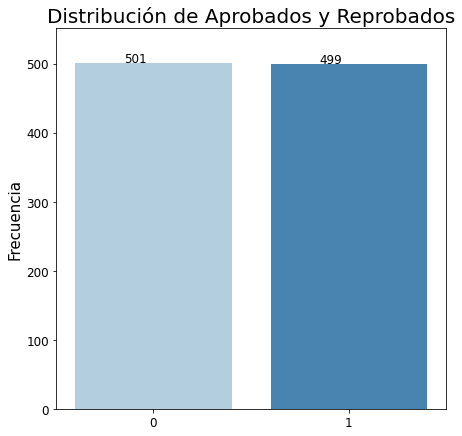

In [4]:
# 0 Reprobado
# 1 Aprobado
cuenta_cat(df,"Pass_Or_Fail",xlabel="",title="Distribución de Aprobados y Reprobados")

Vemos que prácticamente los datos están balanceados. 

En seguida mostramos la gráfica de la distribución de horas que estudian los alumnos por dia:

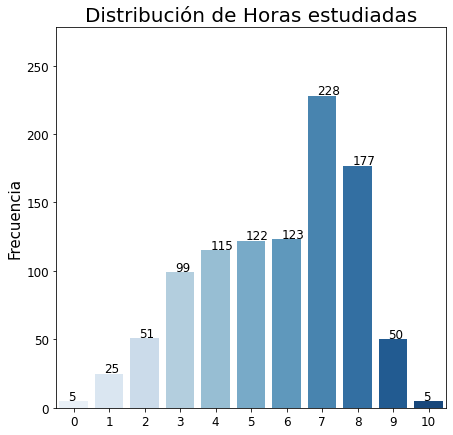

In [5]:
cuenta_cat(df,"Self_Study_Daily",xlabel="",title="Distribución de Horas estudiadas")

Tal como observamos, la mayoría de los alumnos estudian 7 horas a la semana, mientras que hay 5 estudiantes que no estudian y 5 que estudian más que los demás. 

Por último, vamos a graficar cuántos estudiantes aprueban o reprueban conforme al número de horas estudiadas:

Text(0.5, 1.0, 'Número de horas estudiadas')

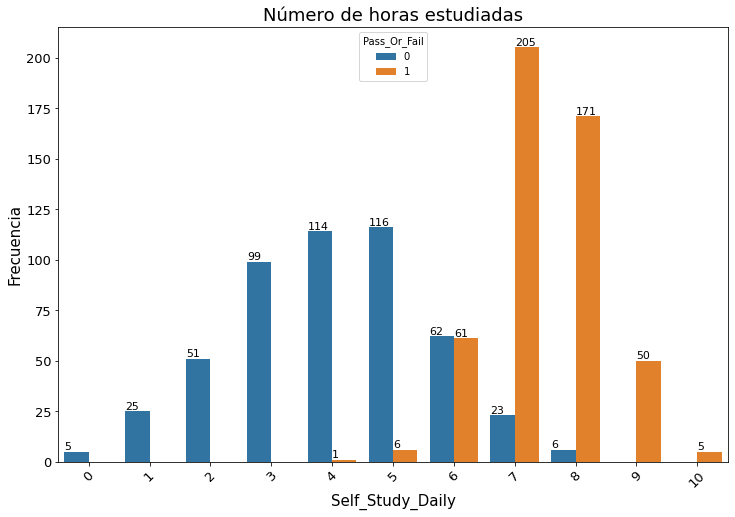

In [6]:
plt.figure(figsize =(12,8))
ax1 = sns.countplot(x = 'Self_Study_Daily', hue = 'Pass_Or_Fail',data=df)
for p in ax1.patches:
  ax1.annotate('{:.0f}'.format(p.get_height()), (p.get_x(), p.get_height()+1),fontsize = 11)
ax1.set_ylabel('Frecuencia',fontsize=15)
ax1.set_xlabel('Self_Study_Daily',fontsize=15)
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.set_title("Número de horas estudiadas",fontsize=18)

Como era de esperarse, los estudiantes que estudian poco reprueban, y los que estudian más horas a la semana lo más seguro es que aprueben.

### Usando Metropolis-Hastings

Ahora sí, echamos a andar el algoritmo M-H para la estimación de los coeficientes para el modelo regresión logística. Es importante mencionar que el número de simulaciones lo tomamos como 20,000 y la proporción que no vamos a considerar (por ser el periodo de quemado) va a ser del 10%.

In [7]:
# hacemos un vector columna para la variable dependiente
y = np.array(dataset[variable_objetivo]).reshape((-1,1))
# hacemos un vector columna para la(s) variable(s) explicativa(s)
X = np.array(dataset[variable_explicativa]).reshape((-1,len(variable_explicativa)))

# hacemos un arreglo para las a prioris de la media de la beta
beta_prioris = np.repeat(0.0, len(variable_explicativa)+1) 
# hacemos un arreglo para las a prioris de la desviacion estandar de la beta
priori_desv_est = np.repeat(1, len(variable_explicativa))
# vector renglon para la desviacion estandar del kernel de transicion
kernel_desv_est = np.repeat(0.1, len(variable_explicativa)+1) 

# numero de simulaciones
Nsim = 20000
# proporcion que quitamos (del periodo de quemado)
quemado = 0.1
# alpha correspondiente al nivel de significancia
alpha = 0.05


### usando la media
# creamos la distribución sin recortar de los hat_beta 
# raw beta
metropolis_hastings = metropolisHastings(y, X, beta_prioris, priori_desv_est, kernel_desv_est, Nsim)
# crea una distribución de beta_hats sin el periodo de quemado
# beta_distr
metropolis_hastings_sin_quemado = sinQuemado(quemado, metropolis_hastings)
# usamos la mediana de las distribuciones de las hat_beats 
# como coeficientes para la prediccion
# beta hat
metropolis_hastings_sin_quemado_ajuste = ajuste(metropolis_hastings_sin_quemado,metodo='media')
# creamos los intervalos de credibilidad
metropolis_hastings_sin_quemado_int_cred = intCred(alpha, metropolis_hastings_sin_quemado)

Lo primero que vamos a hacer es comparar la estimación del vector $\hat{\beta} = [\hat{\beta}_0, \hat{\beta}_1]$ usando la media, la mediana y la moda, para que en un principio notemos con cuál de estas nos acercamos más a la estimación de los parámetros usando la estimación por máxima verosimilitud.

In [8]:
beta_0_media, beta_1_media = metropolis_hastings_sin_quemado_ajuste
print("hat_beta sin el periodo de calentamiento, usando como estimación la media")
print("hat_beta_0: ", beta_0_media[0])
print("hat_beta_1: ", beta_1_media[0])

hat_beta sin el periodo de calentamiento, usando como estimación la media
hat_beta_0:  -13.269155276010528
hat_beta_1:  2.184731682857929


In [9]:
# beta hat
metropolis_hastings_sin_quemado_ajuste2 = ajuste(metropolis_hastings_sin_quemado,metodo='mediana')

beta_0_mediana, beta_1_mediana = metropolis_hastings_sin_quemado_ajuste2
print("hat_beta sin el periodo de calentamiento, usando como estimación la mediana")
print("hat_beta_0: ", beta_0_mediana[0])
print("hat_beta_1: ", beta_1_mediana[0])

hat_beta sin el periodo de calentamiento, usando como estimación la mediana
hat_beta_0:  -13.289322149138346
hat_beta_1:  2.1896579087768333


In [10]:
# beta hat
metropolis_hastings_sin_quemado_ajuste3 = ajuste(metropolis_hastings_sin_quemado,metodo='moda')

beta_0_moda, beta_1_moda = metropolis_hastings_sin_quemado_ajuste3
print("hat_beta sin el periodo de calentamiento, usando como estimación la moda")
print("hat_beta_0: ", beta_0_moda[0])
print("hat_beta_1: ", beta_1_moda[0])

hat_beta sin el periodo de calentamiento, usando como estimación la moda
hat_beta_0:  -11.826323113847401
hat_beta_1:  1.9060011519016065


En principio, vemos primero que con la media y la mediana obtenemos valores muy parecidos (tanto en $\hat{\beta}_0$ como en $\hat{\beta}_1$), mientras que con la moda hay mayor diferencia, aunque tampoco está tan alejada. Lo que sigue es ajustar el modelo usando MLE, pero aquí nos basamos de una biblioteca de python, ya que este ajuste es bien conocido y realmente no merece hacerlo a mano.

### Usando MLE

In [11]:
# agregamos el intercepto pues statsmodels no lo considera
df['Intercepto'] = 1

# ajustamos la regresion logistica usando MLE
mle_mod = Logit(df[variable_objetivo], df[['Intercepto'] + variable_explicativa])
mle_mod_fit = mle_mod.fit(disp=False)

# summary
print(mle_mod_fit.summary())

                           Logit Regression Results                           
Dep. Variable:           Pass_Or_Fail   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Tue, 15 Jun 2021   Pseudo R-squ.:                  0.6834
Time:                        04:26:58   Log-Likelihood:                -219.42
converged:                       True   LL-Null:                       -693.15
Covariance Type:            nonrobust   LLR p-value:                4.734e-208
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercepto         -13.6407      0.958    -14.234      0.000     -15.519     -11.762
Self_Study_Daily     2.2435      0.152     14.739      0.000       1.945       2.542


Podemos notar que con la mediana tenemos resultados muy parecidos a MLE (viendo coef en intercept de la tablita que acaba de arrojarnos).  

Ahora, vamos a graficar la cadena marginal (de $\hat{\beta}_0$ y $\hat{\beta}_1$) y conjunta, la distribución de $\hat{\beta}_0$ y $\hat{\beta}_1$ con sus intervalos de credibilidad al 95% y la convergencia ergódica de estas dos.

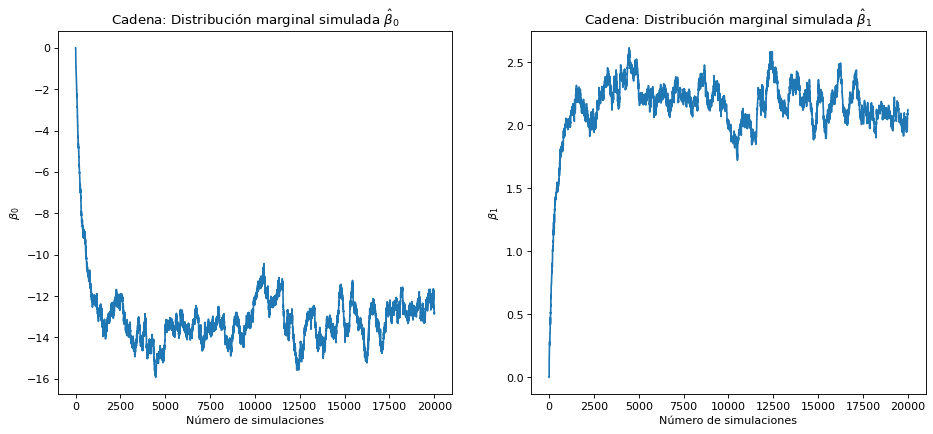

In [12]:
plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.plot(metropolis_hastings[0])
plt.title(r'Cadena: Distribución marginal simulada $\hat{\beta}_0$', fontsize=12)
plt.xlabel('Número de simulaciones', fontsize=10)
plt.ylabel(r'$\beta_0$', fontsize=10)

plt.subplot(1, 2, 2)
plt.plot(metropolis_hastings[1])
plt.title(r'Cadena: Distribución marginal simulada $\hat{\beta}_1$', fontsize=12)
plt.xlabel('Número de simulaciones', fontsize=10)
plt.ylabel(r'$\beta_1$', fontsize=10)
plt.show()

En los dos coeficientes estimados, parece ser que a partir de la simulación 2500 como que empieza a estabilizarse, aunque de alguna forma sí hay un poco de volatilidad.

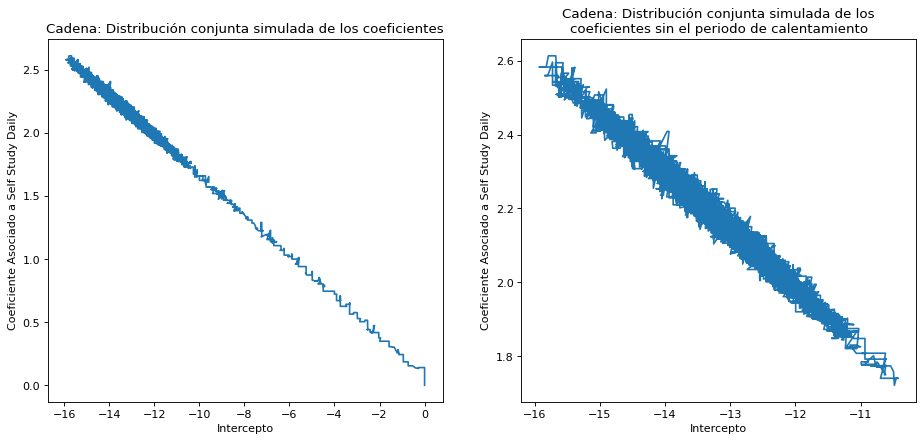

In [13]:
plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.plot(metropolis_hastings[0], metropolis_hastings[1])
plt.title('Cadena: Distribución conjunta simulada de los coeficientes', fontsize=12)
plt.xlabel('Intercepto', fontsize=10)
plt.ylabel('Coeficiente Asociado a Self Study Daily', fontsize=10)

plt.subplot(1, 2, 2)
plt.plot(metropolis_hastings_sin_quemado[0], metropolis_hastings_sin_quemado[1])
plt.title('Cadena: Distribución conjunta simulada de los\ncoeficientes sin el periodo de calentamiento', fontsize=12)
plt.xlabel('Intercepto', fontsize=10)
plt.ylabel('Coeficiente Asociado a Self Study Daily', fontsize=10)
plt.show();


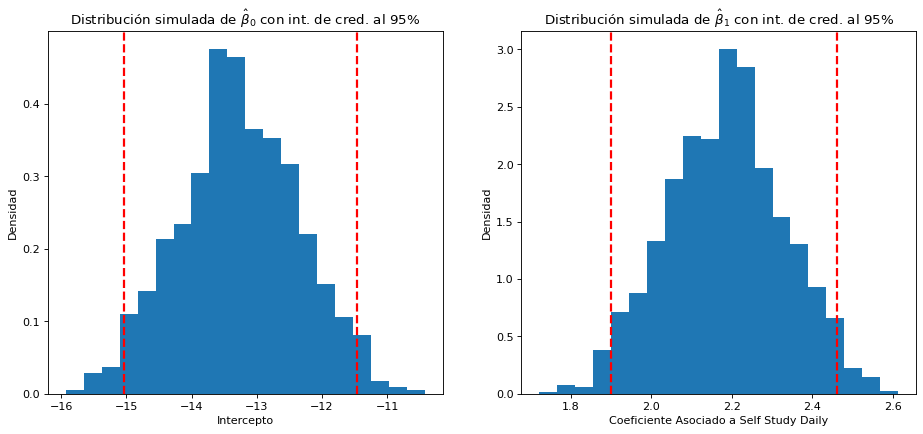

In [14]:
plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.hist(metropolis_hastings_sin_quemado[0], density=True, bins=20)
plt.title(r'Distribución simulada de $\hat{\beta}_0$ con int. de cred. al 95%', 
          fontsize=12)
plt.xlabel('Intercepto', fontsize=10)
plt.ylabel('Densidad', fontsize=10)
plt.axvline(x=metropolis_hastings_sin_quemado_int_cred[0,0], color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=metropolis_hastings_sin_quemado_int_cred[0,1], color='r', linestyle='dashed', linewidth=2)

plt.subplot(1, 2, 2)
plt.hist(metropolis_hastings_sin_quemado[1], density=True, bins=20)
plt.title(r'Distribución simulada de $\hat{\beta}_1$ con int. de cred. al 95%', 
          fontsize=12)
plt.xlabel('Coeficiente Asociado a Self Study Daily', fontsize=10)
plt.ylabel('Densidad', fontsize=10)
plt.axvline(x=metropolis_hastings_sin_quemado_int_cred[1,0], color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=metropolis_hastings_sin_quemado_int_cred[1,1], color='r', linestyle='dashed', linewidth=2)
plt.show();

Creemos que las distribuciones tienen un comportamiento adecuado.

In [15]:
beta_0 = metropolis_hastings[0]
beta_1 = metropolis_hastings[1]

suma_acumulada_beta_0 = np.cumsum(beta_0)[1:]
suma_acumulada_beta_1 = np.cumsum(beta_1)[1:]
iteraciones = np.arange(1, Nsim+1)

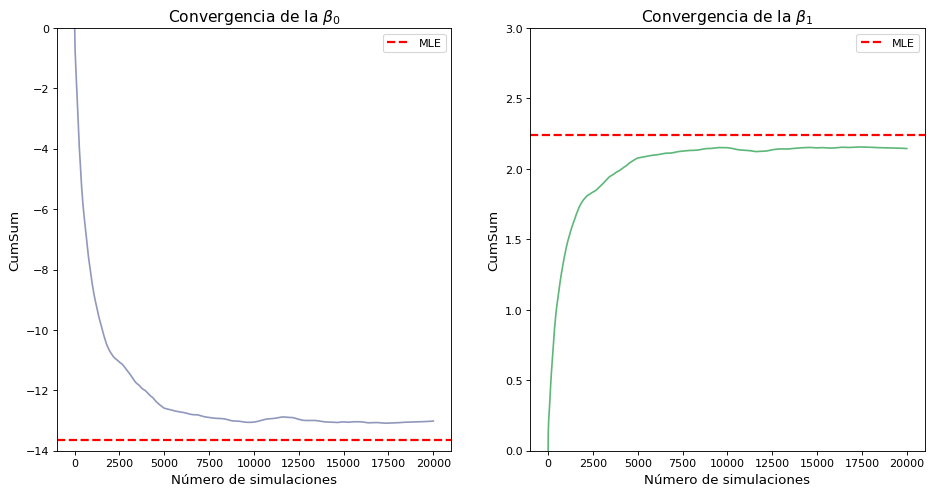

In [16]:
plt.figure(figsize=(14, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.plot(iteraciones, suma_acumulada_beta_0/iteraciones, color='#9098BC')
plt.title(r'Convergencia de la $\beta_0$', fontsize=14)
plt.xlabel('Número de simulaciones', fontsize=12)
plt.ylabel('CumSum', fontsize=12)
plt.axhline(mle_mod_fit.params[0], color='r', linestyle='dashed', linewidth=2, label='MLE')
plt.ylim(-14, 0)
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(iteraciones, suma_acumulada_beta_1/iteraciones, color='#5DB779')
plt.title(r'Convergencia de la $\beta_1$', fontsize=14)
plt.xlabel('Número de simulaciones', fontsize=12)
plt.ylabel('CumSum', fontsize=12)
plt.axhline(mle_mod_fit.params[1], color='r', linestyle='dashed', linewidth=2, label='MLE')
plt.ylim(0, 3)
plt.legend()
plt.show()

En estas últimas dos gráficas vemos que ambos coeficientes estimados convergen. 

Finalmente, a pesar de que con M-H y MLE tenemos resultados similares, vamos a predecir los valores reales de la base de datos basándonos en los coeficientes estimados (usando la media); y evaluar cuál modelo es  mejor  (1 es con los coeficientes usando M-H y otro es usando MLE). 

In [17]:
# coeficientes con M-H usando la media
metropolis_hastings_sin_quemado_ajuste

array([[-13.26915528],
       [  2.18473168]])

In [18]:
# coeficientes usando MLE
coeficientes_mle = np.array([[mle_mod_fit.params[0]],[mle_mod_fit.params[1]]])
coeficientes_mle

array([[-13.64065302],
       [  2.24352716]])

In [19]:
df['Pass_Or_Fail_Pred_MH'] = prediccionClases(X,metropolis_hastings_sin_quemado_ajuste).reshape(-1,1)
df['Pass_Or_Fail_Pred_MLE'] = prediccionClases(X,coeficientes_mle).reshape(-1,1)


In [20]:
print("Exactitud (Accuracy) usando M-H: ", accuracy_score(df['Pass_Or_Fail'].to_numpy(), df['Pass_Or_Fail_Pred_MH'].to_numpy()))
print("Exactitud (Accuracy) usando MLE: ", accuracy_score(df['Pass_Or_Fail'].to_numpy(), df['Pass_Or_Fail_Pred_MLE'].to_numpy()))

Exactitud (Accuracy) usando M-H:  0.903
Exactitud (Accuracy) usando MLE:  0.903


Obtenemos la misma exactitud con ambas técnicas. Parece ser que con las dos obtenemos un buen modelo, pues el accuracy es cercano a 1. Como los estimadores usando la media y la mediana son muy parecidos, no vale la pena compararlos. Por ello, solamente vamos a calcular las predicciones (y su exactitud) con los coeficientes estimados usando la moda (pues anteriormente vimos que eran un poco distintos a los otros) y usando los coeficientes del segundo modelo que ajustamos en STAN (con distribuciones a priori: $N(0,1)$ para $\beta_0$ y  $N(1,1)$ para $\beta_1$).

El segundo notebook (el que contiene todo lo relacionado a STAN) se encuentra también en el correspondiente repositorio de la materia en github.

In [21]:
# coeficientes del modelo 2 con STAN
coeficientes_stan = np.array([[-8.872111],[1.492862]])

In [22]:
df['Pass_Or_Fail_Pred_MH_Moda'] = prediccionClases(X,metropolis_hastings_sin_quemado_ajuste3).reshape(-1,1)
df['Pass_Or_Fail_Pred_STAN'] = prediccionClases(X,coeficientes_stan).reshape(-1,1)

print("Exactitud (Accuracy) usando la moda con M-H: ", accuracy_score(df['Pass_Or_Fail'].to_numpy(), df['Pass_Or_Fail_Pred_MH_Moda'].to_numpy()))
print("Exactitud (Accuracy) con los coef. del modelo 2 en STAN: ", accuracy_score(df['Pass_Or_Fail'].to_numpy(), df['Pass_Or_Fail_Pred_STAN'].to_numpy()))


Exactitud (Accuracy) usando la moda con M-H:  0.903
Exactitud (Accuracy) con los coef. del modelo 2 en STAN:  0.902


De igual manera, tenemos prácticamente la misma exactitud (un valor predicho incorrectamente más usando los coeficientes de STAN, pues son 1000 datos)





# Conclusiones

Con respecto a lo que hemos estado mencionado a lo largo de este proyecto, con estos datos podemos decir que el ajuste usando diferentes técnicas para estimar los coeficienetes es bueno en todas, de hecho, al evaluar los modelos, prácticamente coinciden en exactitud. Considero que esto se debe a que, como lo pudimos observar en el análisis exploratorio de datos, si el alumno estudia pocas horas al día, casi siempre va a pasar que repruebe (y esto no es nuevo, sobretodo en la universidad y más si cursas con el Dr. Alan Riva Palacio jeje). A lo que me refiero es, parece ser que la 'línea de separación' entre clases está desde un principio relativamente delimitada por las horas de estudio diarias, y entonces pequeños cambios en los coeficientes estimados en la regresión logística quizás no sean muy significativo para efectar en las predicciones.

Sin embargo, podemos rescatar que el intercepto en todos los modelos siempre fue negativo (más aún, fue un número entre -14 y -8) y el coeficiente asociado a la variable de horas de estudio diarias resultó en ser positivo (un número entre 1 y 3).


Por ello, concluimos que siempre es importante comparar varios modelos para buscar el más adecuado, aunque nosotros obtuviéramos que todos resultaron buenos; y no descartar algoritmos MCMC pues quizás en otras circunstancias sí se aprecie su mejora con respecto a los convencionales; aunque la desventaja es que su ejecución llega a ser más tardada.